# Ultramarathon

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gpxpy

In [4]:
data_path = "Ultramarathon_1.gpx"

In [19]:
with open(data_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
    
# convert to a dataframe
points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            # Extract extension data
            power = None
            hr = None
            cad = None
            
            if point.extensions:
                for ext in point.extensions:
                    if ext.tag == 'power':
                        power = int(ext.text) if ext.text else None
                    elif ext.tag.endswith('TrackPointExtension'):
                        for child in ext:
                            if child.tag.endswith('hr'):
                                hr = int(child.text) if child.text else None
                            elif child.tag.endswith('cad'):
                                cad = int(child.text) if child.text else None
            
            points.append({
                'time': point.time,
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation,
                'power': power,
                'heart_rate': hr,
                'cadence': cad
            })

df = pd.DataFrame.from_records(points)

<Axes: >

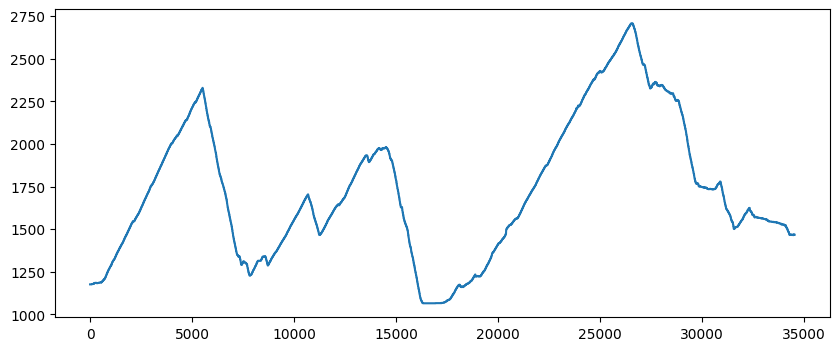

In [41]:
df.elevation.plot(figsize=(10,4))

Either approximate this graph with line segments by using an algorithm with a minimum nr? and minimum lines segment length

Or go over the graph

<Axes: >

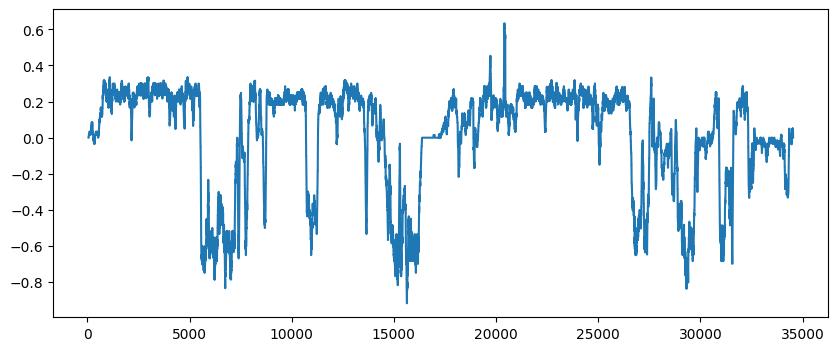

In [42]:
# smooth the elevation
smoothing_window = 60
df["elevation_sma"] = df["elevation"].rolling(window=smoothing_window).mean()
df["elevation_sma"].diff().plot(figsize=(10,4))

In [ ]:
window_size = 35

# get mean incline over window
df['incline'] = df["elevation_sma"].diff().rolling(window=window_size).mean()

# We want to get the points where the incline changes significantly compared to the previous point
incline_threshold = 0.5  # Define a threshold for significant incline change

approx_points = []

incline_at_last_point = 0
for idx, row in df.iterrows():
    pass

<Axes: >

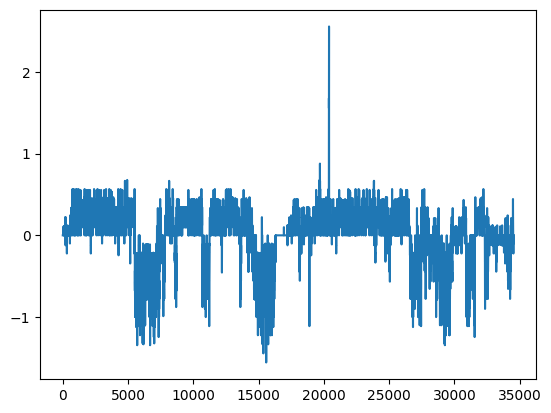

In [24]:
df["incline"].plot()

In [52]:
df["length"] = np.sqrt(df["latitude"].diff()**2 + df["longitude"].diff()**2 + df["elevation"].diff()**2) 
df["length"] = df["length"].cumsum()

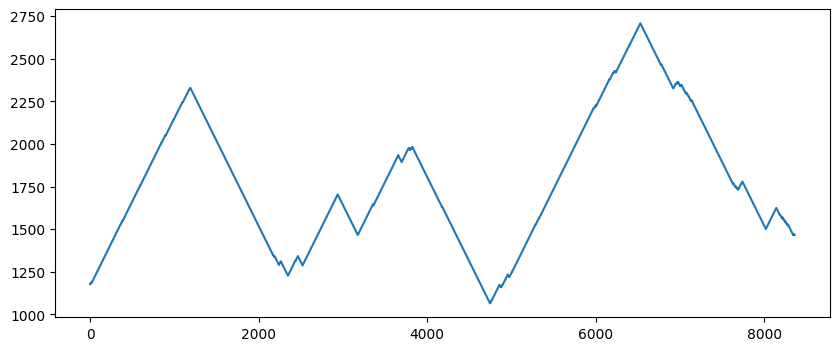

In [53]:
plt.figure(figsize=(10,4))
plt.plot(df["length"], df["elevation"])